# Hotel Rating Classification 

## Problem Statement

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import nltk
import string

from sklearn.model_selection import train_test_split, KFold, cross_val_score

from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, plot_confusion_matrix, balanced_accuracy_score

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.base import BaseEstimator, TransformerMixin

from textblob import TextBlob
from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline, make_pipeline

from sklearn_pandas import DataFrameMapper
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Binarizer, FunctionTransformer 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score


#from pickle import dumps
from pickle import load

from dill import dumps as dp
from dill import loads as ld 
from cloudpickle import dump
import joblib

import warnings
warnings.filterwarnings('ignore')

### Import the dataset

In [2]:
data = pd.read_excel("C:/Users/Dhanashree/Downloads/hotel_reviews.xlsx")
data

Review  Rating
0      nice hotel expensive parking got good deal sta...     4.0
1      ok nothing special charge diamond member hilto...     2.0
2      nice rooms not 4* experience hotel monaco seat...     3.0
3      unique, great stay, wonderful time hotel monac...     5.0
4      great stay great stay, went seahawk game aweso...     5.0
...                                                  ...     ...
20486  best kept secret 3rd time staying charm, not 5...     5.0
20487  great location price view hotel great quick pl...     4.0
20488  ok just looks nice modern outside, desk staff ...     2.0
20489  hotel theft ruined vacation hotel opened sept ...     1.0
20490  people talking, ca n't believe excellent ratin...     2.0

[20491 rows x 2 columns]

In [3]:
data[data.duplicated()]

Empty DataFrame
Columns: [Review, Rating]
Index: []

### EDA

In [4]:
data.shape

(20491, 2)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Review  20491 non-null  object 
 1   Rating  20491 non-null  float64
dtypes: float64(1), object(1)
memory usage: 320.3+ KB


In [6]:
data.isnull().sum()

Review    0
Rating    0
dtype: int64

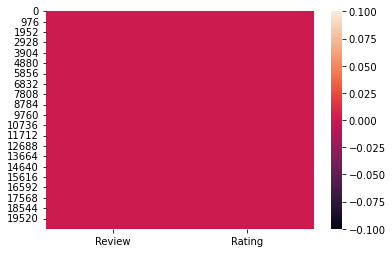

In [7]:
sns.heatmap(data.isnull());

In [8]:
correlations=data.corr()
correlations

Rating
Rating     1.0

In [9]:
data.duplicated().sum()

0

In [10]:
data.describe()

Rating
count  20491.000000
mean       3.952223
std        1.233030
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000

In [11]:
sorted(data['Rating'].unique())

[1.0, 2.0, 3.0, 4.0, 5.0]

In [12]:
data['Rating'] = data['Rating'].astype('int')

In [13]:
data['Rating'].value_counts()

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

In [14]:
### There are no null values & duplicates data in our dataset.

### Data Visualization

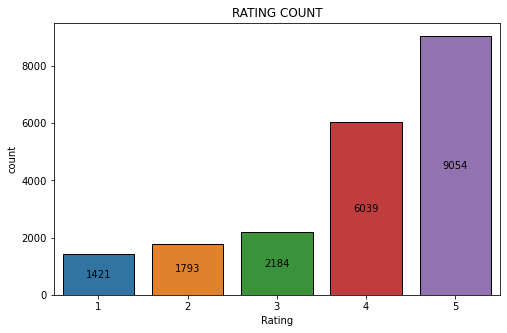

In [15]:
plt.figure(figsize=(8,5))

ax = sns.countplot(data = data , x = 'Rating', edgecolor='black', linewidth=1)

for i in ax.containers:
    ax.bar_label(i, label_type='center')
    
plt.title('RATING COUNT')
plt.show()

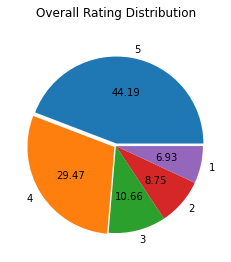

In [16]:
plt.pie(data['Rating'].value_counts(), autopct='%0.2f', labels=['5', '4', '3', '2', '1'], explode=[0.03, 0.02, 0.0, 0.0, 0.0])
plt.title('Overall Rating Distribution\n')
plt.show()

<AxesSubplot:xlabel='Rating', ylabel='Density'>

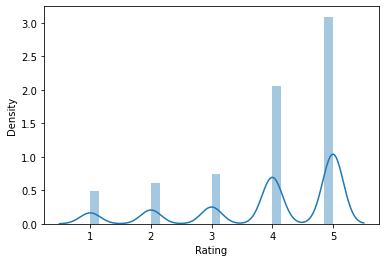

In [17]:
sns.distplot(data['Rating'])

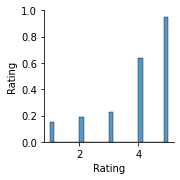

In [18]:
sns.pairplot(data)

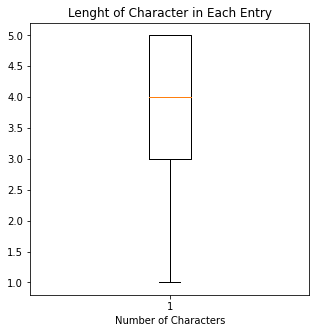

In [19]:
## Outliers

fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(data['Rating'])
plt.title("Lenght of Character in Each Entry")
plt.xlabel('Number of Characters')
plt.show()

In [20]:
### There is no outerlier detected because we don't have categorical data.
### We have less no. of negative ratings provided by users.
### Thus, it is highly imbalanced dataset.

### Text Preprocessing

In [21]:
##Converting To Lowercase and Replace

data['Review_clean']=data['Review'].str.replace('[^a-zA-Z\s]','')
data['Review_clean'][:2].values

array(['nice hotel expensive parking got good deal stay hotel anniversary arrived late evening took advice previous reviews did valet parking check quick easy little disappointed nonexistent view room room clean nice size bed comfortable woke stiff neck high pillows not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway maybe just noisy neighbors aveda bath products nice did not goldfish stay nice touch taken advantage staying longer location great walking distance shopping overall nice experience having pay  parking night  ',
       'ok nothing special charge diamond member hilton decided chain shot th anniversary seattle start booked suite paid extra website description not suite bedroom bathroom standard hotel room took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast got kidding embassy suits sitting room bathroom bedroom unlike kimp

### Tokenization

In [22]:
import re
def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    lemmatizer= WordNetLemmatizer()
    lemma_words=[lemmatizer.lemmatize(w) for w in filtered_words]
    return " ".join(lemma_words)

### Removing Stopwords

In [23]:
from nltk.corpus import stopwords
import nltk
stopwrds=set(stopwords.words("english"))
from sklearn.feature_extraction.text import CountVectorizer
def get_bigram(data,n):
   
    vec=CountVectorizer(ngram_range=(2,2),stop_words=stopwrds).fit(data)
    bag_of_words=vec.transform(data)
    sum_words=bag_of_words.sum(0)
    word_freq=[(word,sum_words[0,idx]) for word,idx in vec.vocabulary_.items()]
    word_freq=sorted(word_freq,key=lambda x:x[1],reverse=True)
    return word_freq[:n]

In [24]:
bigram_rat1=get_bigram(data.loc[data['Rating']==1,'Review'].apply(lambda x:" ".join(sent for sent in x.split() 
                                                        if sent not in ['did','not','hotel','room','does'])),10)
bigram_rat1

[('punta cana', 151),
 ('credit card', 114),
 ('customer service', 108),
 ('stay away', 80),
 ('air conditioning', 78),
 ('travel agent', 66),
 ('san juan', 62),
 ('hot water', 61),
 ('desk staff', 57),
 ('new orleans', 54)]

In [25]:
bigram_rat2=get_bigram(data.loc[data['Rating']==2,'Review'].apply(lambda x:" ".join(sent for sent in x.split()
                                                        if sent not in ['did','not','hotel','room','does'])),10)
bigram_rat2

[('punta cana', 201),
 ('air conditioning', 142),
 ('staff friendly', 128),
 ('san juan', 100),
 ('great location', 97),
 ('make sure', 89),
 ('stayed nights', 88),
 ('good location', 78),
 ('customer service', 75),
 ('non smoking', 73)]

In [26]:
bigram_rat3=get_bigram(data.loc[data['Rating']==3,'Review'].apply(lambda x:" ".join(sent for sent in x.split()
                                                    if sent not in ['did','not','hotel','room','does'])),10)
bigram_rat3

[('great location', 251),
 ('staff friendly', 242),
 ('punta cana', 207),
 ('good location', 176),
 ('stayed nights', 146),
 ('walking distance', 135),
 ('san juan', 130),
 ('good value', 122),
 ('location great', 114),
 ('make sure', 114)]

In [27]:
bigram_rat4=get_bigram(data.loc[data['Rating']==4,'Review'].apply(lambda x:" ".join(sent for sent in x.split()
                                                        if sent not in ['did','not','hotel','room','does'])),10)
bigram_rat4

[('great location', 845),
 ('staff friendly', 763),
 ('punta cana', 565),
 ('walking distance', 528),
 ('friendly helpful', 503),
 ('staff helpful', 416),
 ('good value', 414),
 ('stayed nights', 409),
 ('minute walk', 402),
 ('great time', 401)]

In [28]:
bigram_rat5=get_bigram(data.loc[data['Rating']==5,'Review'].apply(lambda x:" ".join(sent for sent in x.split()
                                                    if sent not in ['did','not','hotel','room','does'])),10)
bigram_rat5

[('great location', 1014),
 ('staff friendly', 1013),
 ('friendly helpful', 777),
 ('highly recommend', 736),
 ('walking distance', 735),
 ('punta cana', 603),
 ('staff helpful', 540),
 ('place stay', 540),
 ('stayed nights', 511),
 ('minute walk', 511)]

In [29]:
#Check for common words in highest rated reviews
set([x[0] for x in bigram_rat3])\
&set([x[0] for x in bigram_rat4])\
&set([x[0] for x in bigram_rat5])

{'great location',
 'punta cana',
 'staff friendly',
 'stayed nights',
 'walking distance'}

In [30]:
#Check for common words in least rated reviews
set([x[0] for x in bigram_rat1])&set([x[0] for x in bigram_rat2])&set([x[0] for x in bigram_rat3])

{'punta cana', 'san juan'}

In [31]:
#Lemmetization

from nltk.stem.wordnet import WordNetLemmatizer
def lemmatise(sentence):
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(sentence)
    lemmatizer = WordNetLemmatizer()
    lemma_words=[lemmatizer.lemmatize(w) for w in tokens]
    return " ".join(lemma_words)

In [32]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
data['cleaned_review']=data['Review'].apply(lambda x :preprocess(x))
data['cleaned_review']

0        nice hotel expensive parking got good deal sta...
1        nothing special charge diamond member hilton d...
2        nice room experience hotel monaco seattle good...
3        unique great stay wonderful time hotel monaco ...
4        great stay great stay went seahawk game awesom...
                               ...                        
20486    best kept secret time staying charm star beat ...
20487    great location price view hotel great quick pl...
20488    look nice modern outside desk staff particular...
20489    hotel theft ruined vacation hotel opened sept ...
20490    people talking believe excellent rating hotel ...
Name: cleaned_review, Length: 20491, dtype: object

In [33]:
data['sentiment']=data['cleaned_review'].apply(lambda x : TextBlob(x).sentiment.polarity)
data.head()

Review  Rating  \
0  nice hotel expensive parking got good deal sta...       4   
1  ok nothing special charge diamond member hilto...       2   
2  nice rooms not 4* experience hotel monaco seat...       3   
3  unique, great stay, wonderful time hotel monac...       5   
4  great stay great stay, went seahawk game aweso...       5   

                                        Review_clean  \
0  nice hotel expensive parking got good deal sta...   
1  ok nothing special charge diamond member hilto...   
2  nice rooms not  experience hotel monaco seattl...   
3  unique great stay wonderful time hotel monaco ...   
4  great stay great stay went seahawk game awesom...   

                                      cleaned_review  sentiment  
0  nice hotel expensive parking got good deal sta...   0.208744  
1  nothing special charge diamond member hilton d...   0.238948  
2  nice room experience hotel monaco seattle good...   0.266138  
3  unique great stay wonderful time hotel monaco ...   0.504825  
4  great stay great stay went seahawk game awesom...   0.469643

In [34]:
def assign_Result(marks):
    if marks < 0:
        result = 'negative'
    elif marks >= 0:
        result = 'positive'

    return result
data['review_segment']=data['sentiment'].apply(assign_Result)
data.head()

Review  Rating  \
0  nice hotel expensive parking got good deal sta...       4   
1  ok nothing special charge diamond member hilto...       2   
2  nice rooms not 4* experience hotel monaco seat...       3   
3  unique, great stay, wonderful time hotel monac...       5   
4  great stay great stay, went seahawk game aweso...       5   

                                        Review_clean  \
0  nice hotel expensive parking got good deal sta...   
1  ok nothing special charge diamond member hilto...   
2  nice rooms not  experience hotel monaco seattl...   
3  unique great stay wonderful time hotel monaco ...   
4  great stay great stay went seahawk game awesom...   

                                      cleaned_review  sentiment review_segment  
0  nice hotel expensive parking got good deal sta...   0.208744       positive  
1  nothing special charge diamond member hilton d...   0.238948       positive  
2  nice room experience hotel monaco seattle good...   0.266138       positive  
3  unique great stay wonderful time hotel monaco ...   0.504825       positive  
4  great stay great stay went seahawk game awesom...   0.469643       positive

### Sentimental Analysis

In [35]:
def get_sentiment(data): 

    analysis = TextBlob(data)
    # set sentiment 
    if analysis.sentiment.polarity > 0: 
        return 'positive'
    elif analysis.sentiment.polarity == 0: 
        return 'neutral'
    else: 
        return 'negative'

In [36]:
a='nice hotel not nice staff hotel lovely staff quite rude, bellhop desk clerk going way make things difficult, waited forever check heavy bags no help getting throught double doors room, worst desk clerk checking tap tap tap car waited pick 20 minutes, got home noticed 1,000 dollar hold credit card took 5 phonecalls 2 faxes 1 week resolved, stay warwck 4th lenora rooms ok..but al friendly faces tiring day airport'

get_sentiment(a)

'negative'

### Vader lexicon

In [37]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

b='nice hotel not nice staff hotel lovely staff quite rude, bellhop desk clerk going way make things difficult, waited forever check heavy bags no help getting throught double doors room, worst desk clerk checking tap tap tap car waited pick 20 minutes, got home noticed 1,000 dollar hold credit card took 5 phonecalls 2 faxes 1 week resolved, stay warwck 4th lenora rooms ok..but al friendly faces tiring day airport'
sia.polarity_scores(b)

{'neg': 0.138, 'neu': 0.639, 'pos': 0.224, 'compound': 0.7584}

In [38]:
def get_vader_sentiment(data): 

    sia = SentimentIntensityAnalyzer()
    # create TextBlob object of passed tweet text 
    analysis = sia.polarity_scores(data)
    # set sentiment 
    if analysis["compound"] > 0: 
        return 'positive'
    elif analysis["compound"] < 0: 
        return 'negative'
    else: 
        return 'neutral'
get_vader_sentiment(b)

'positive'

In [39]:
data['review_segment']=data['sentiment'].apply(assign_Result)
data

Review  Rating  \
0      nice hotel expensive parking got good deal sta...       4   
1      ok nothing special charge diamond member hilto...       2   
2      nice rooms not 4* experience hotel monaco seat...       3   
3      unique, great stay, wonderful time hotel monac...       5   
4      great stay great stay, went seahawk game aweso...       5   
...                                                  ...     ...   
20486  best kept secret 3rd time staying charm, not 5...       5   
20487  great location price view hotel great quick pl...       4   
20488  ok just looks nice modern outside, desk staff ...       2   
20489  hotel theft ruined vacation hotel opened sept ...       1   
20490  people talking, ca n't believe excellent ratin...       2   

                                            Review_clean  \
0      nice hotel expensive parking got good deal sta...   
1      ok nothing special charge diamond member hilto...   
2      nice rooms not  experience hotel monaco seattl...   
3      unique great stay wonderful time hotel monaco ...   
4      great stay great stay went seahawk game awesom...   
...                                                  ...   
20486  best kept secret rd time staying charm not sta...   
20487  great location price view hotel great quick pl...   
20488  ok just looks nice modern outside desk staff n...   
20489  hotel theft ruined vacation hotel opened sept ...   
20490  people talking ca nt believe excellent ratings...   

                                          cleaned_review  sentiment  \
0      nice hotel expensive parking got good deal sta...   0.208744   
1      nothing special charge diamond member hilton d...   0.238948   
2      nice room experience hotel monaco seattle good...   0.266138   
3      unique great stay wonderful time hotel monaco ...   0.504825   
4      great stay great stay went seahawk game awesom...   0.469643   
...                                                  ...        ...   
20486  best kept secret time staying charm star beat ...   0.209229   
20487  great location price view hotel great quick pl...   0.463333   
20488  look nice modern outside desk staff particular...   0.145929   
20489  hotel theft ruined vacation hotel opened sept ...   0.145881   
20490  people talking believe excellent rating hotel ...   0.110615   

      review_segment  
0           positive  
1           positive  
2           positive  
3           positive  
4           positive  
...              ...  
20486       positive  
20487       positive  
20488       positive  
20489       positive  
20490       positive  

[20491 rows x 6 columns]

In [40]:
sia.polarity_scores(data.loc[0]['Review'])

{'neg': 0.072, 'neu': 0.643, 'pos': 0.285, 'compound': 0.9747}

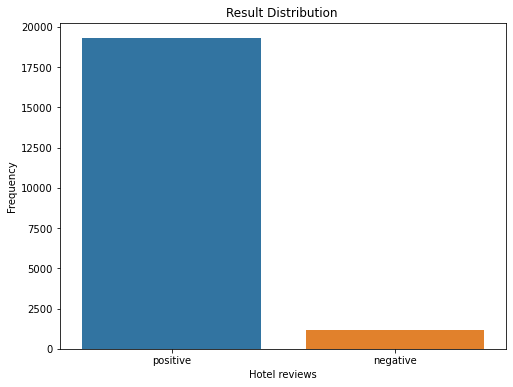

In [41]:
from six import text_type
x=data['review_segment'].value_counts()
plt.figure(figsize=(8,6))
sns.barplot(x.index,x.values)
plt.title('Result Distribution ')
plt.ylabel('Frequency', fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Hotel reviews', fontsize=10)
plt.xticks(fontsize=10)
plt.show()

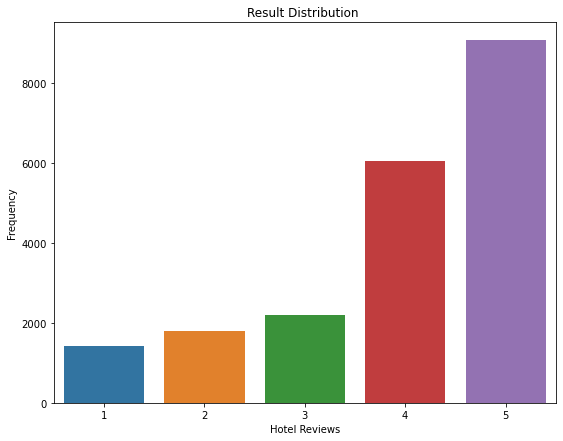

In [42]:
x=data['Rating'].value_counts()
plt.figure(figsize=(9,7))
sns.barplot(x.index,x.values)
plt.title('Result Distribution ')
plt.ylabel('Frequency', fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Hotel Reviews', fontsize=10)
plt.xticks(fontsize=10)
plt.show()

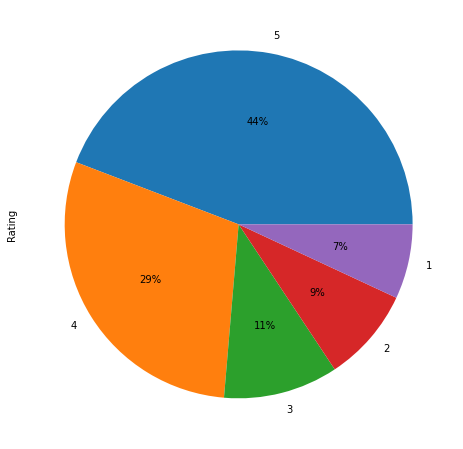

In [43]:
plt.figure(figsize=(10,8))
data['Rating'].value_counts().plot(kind='pie',autopct='%1.0f%%')
plt.show()

In [44]:
def lemmatise(sentence):
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(sentence)
    lemmatizer = WordNetLemmatizer()
    lemma_words=[lemmatizer.lemmatize(w) for w in tokens]
    return " ".join(lemma_words)
tokenizer = RegexpTokenizer(r'\w+')
data['lemmatized_content']=data['cleaned_review'].map(lambda x : tokenizer.tokenize(lemmatise(x)))
data['lemmatized_content']

0        [nice, hotel, expensive, parking, got, good, d...
1        [nothing, special, charge, diamond, member, hi...
2        [nice, room, experience, hotel, monaco, seattl...
3        [unique, great, stay, wonderful, time, hotel, ...
4        [great, stay, great, stay, went, seahawk, game...
                               ...                        
20486    [best, kept, secret, time, staying, charm, sta...
20487    [great, location, price, view, hotel, great, q...
20488    [look, nice, modern, outside, desk, staff, par...
20489    [hotel, theft, ruined, vacation, hotel, opened...
20490    [people, talking, believe, excellent, rating, ...
Name: lemmatized_content, Length: 20491, dtype: object

In [45]:
words=data['lemmatized_content']
allwords=[]
for wordlist in words:
    allwords+=wordlist
print(allwords)
print('length of all words : ',len(allwords))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Most Common Words

In [46]:
## For checking most used words

def wordCloud_generator(data, title=None):
    wordcloud = WordCloud(width = 1000, height = 750, max_words=300,
                          #background_color ='white',
                          min_font_size = 10
                         ).generate(" ".join(data.values))
                        
    plt.figure(figsize = (6, 5), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=25)
    plt.show() 

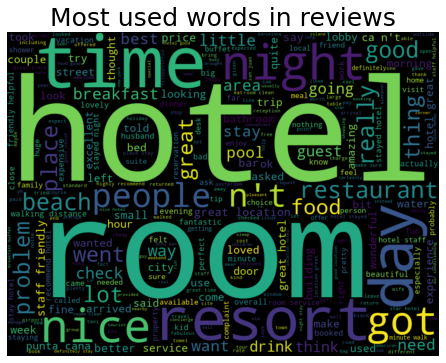

In [47]:
wordCloud_generator(data=data['Review'], title="Most used words in reviews")

In [48]:
#Checking the most used words from reviews 

def wordCloud_generator(data, title=None):
    wordcloud = WordCloud(width = 1000, height = 750, max_words=300,
                          min_font_size = 10
                         ).generate(" ".join(data.values))
                        
    plt.figure(figsize = (6, 5), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=25)
    plt.show() 

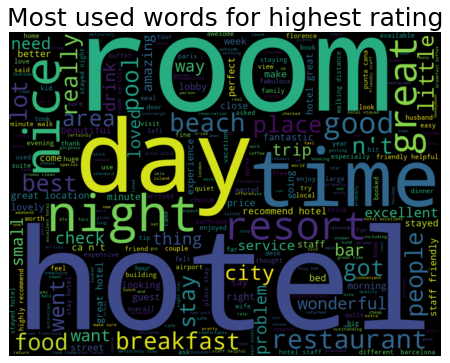

In [49]:
wordCloud_generator(data=data[data['Rating']==5]['Review'], title="Most used words for highest rating")

In [50]:
#Checking the most used words from reviews 

def wordCloud_generator(data, title=None):
    wordcloud = WordCloud(width = 1000, height = 750, max_words=300,
                          min_font_size = 10
                         ).generate(" ".join(data.values))
                        
    plt.figure(figsize = (6, 5), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=25)
    plt.show() 

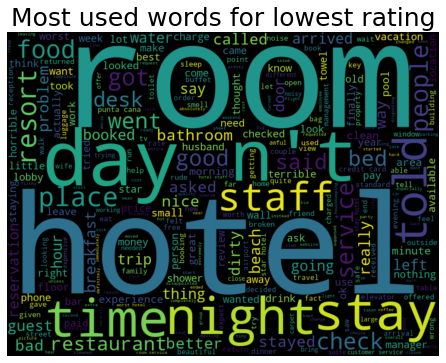

In [51]:
wordCloud_generator(data=data[data['Rating']==1]['Review'],title="Most used words for lowest rating")

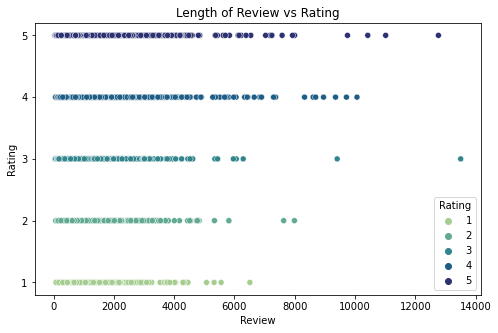

In [52]:
#Checking the length of words in a review for all the rating

plt.figure(figsize=(8,5))
sns.scatterplot(x=data['Review'].apply(len), y=data['Rating'], data=data, palette='crest', hue='Rating')
plt.title('Length of Review vs Rating')
plt.yticks([1,2,3,4,5])
plt.show()

In [53]:
from collections import Counter
mostfreq=data.groupby('Rating')['cleaned_review'].apply(lambda x : Counter(' '.join(x).split()).most_common(25))
mostfreq

Rating
1    [(room, 4294), (hotel, 4002), (stay, 1246), (d...
2    [(room, 5772), (hotel, 4657), (night, 1618), (...
3    [(room, 6128), (hotel, 5628), (good, 2523), (n...
4    [(hotel, 15535), (room, 14238), (great, 7572),...
5    [(hotel, 24164), (room, 17314), (great, 10886)...
Name: cleaned_review, dtype: object

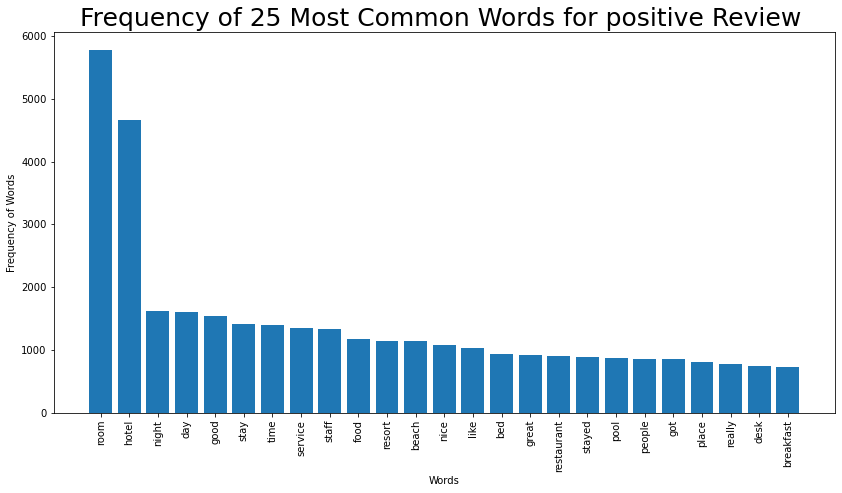

In [54]:
positive=mostfreq.iloc[1]
words=list(zip(*positive))[0]
freq=list(zip(*positive))[1]


plt.figure(figsize=(14,7))
plt.bar(words, freq)
plt.xlabel('Words', fontsize=10)
plt.ylabel('Frequency of Words', fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(rotation=90, fontsize=10)
plt.title('Frequency of 25 Most Common Words for positive Review ', fontsize=25)
plt.show()

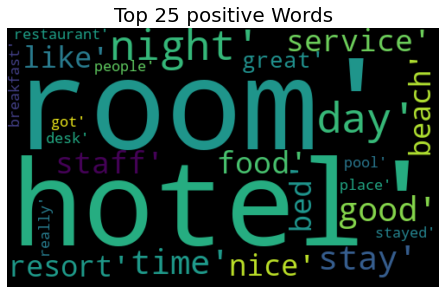

In [55]:
from wordcloud import WordCloud, ImageColorGenerator
wordcloud=WordCloud(width=500, height=300, background_color='black').generate(str(positive))
fig = plt.figure(figsize=(6,4), facecolor='white')
plt.title('Top 25 positive Words', fontsize=20)
plt.axis('off')
plt.imshow(wordcloud, interpolation="bilinear")
plt.tight_layout(pad=0)
plt.show()

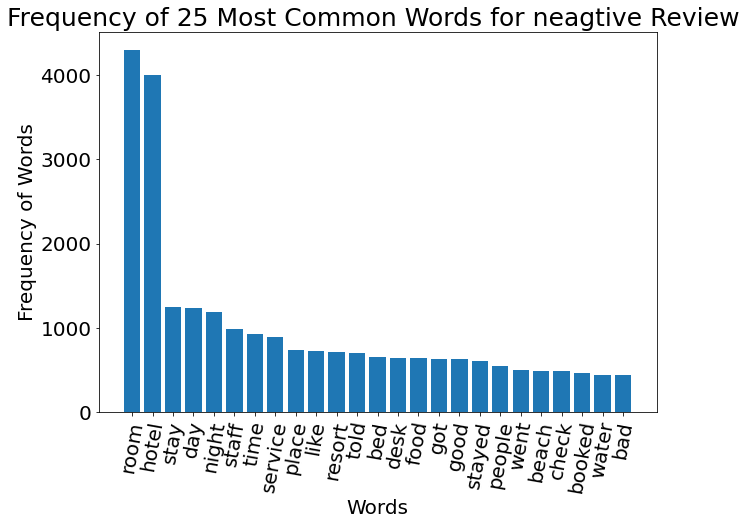

In [56]:
neagtive=mostfreq.iloc[0]
words=list(zip(*neagtive))[0]
freq=list(zip(*neagtive))[1]


plt.figure(figsize=(10,7))
plt.bar(words, freq)
plt.xlabel('Words', fontsize=20)
plt.ylabel('Frequency of Words', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(rotation=80, fontsize=20)
plt.title('Frequency of 25 Most Common Words for neagtive Review ', fontsize=25)
plt.show()

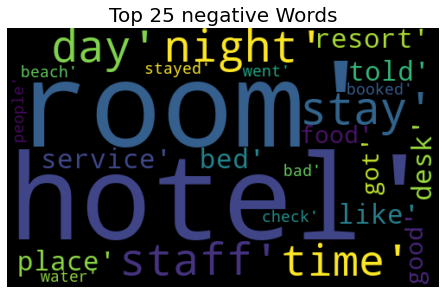

In [57]:
from wordcloud import WordCloud, ImageColorGenerator
neagtive=mostfreq.iloc[0]
words=list(zip(*neagtive))[0]
freq=list(zip(*neagtive))[1]
wordcloud=WordCloud(width=500, height=300, background_color='black').generate(str(neagtive))
fig = plt.figure(figsize=(6,4), facecolor='white')
plt.title('Top 25 negative Words', fontsize=20)
plt.axis('off')
plt.imshow(wordcloud, interpolation="bilinear")
plt.tight_layout(pad=0)
plt.show()

In [58]:
## length of review has an effect on ratings.
## Lower ratings have lower length of review compared to top ratings.
## Positive correlation between Length of Reviews & Ratings.

### Using Count vectorizer

In [59]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1,2))
X = vectorizer.fit_transform(words)
print(X.toarray())

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 

In [60]:
vocab = vectorizer.vocabulary_
vocab

{'room': 16,
 'hotel': 10,
 'stay': 19,
 'day': 5,
 'night': 12,
 'staff': 18,
 'time': 21,
 'service': 17,
 'place': 14,
 'like': 11,
 'resort': 15,
 'told': 22,
 'bed': 2,
 'desk': 6,
 'food': 7,
 'got': 9,
 'good': 8,
 'stayed': 20,
 'people': 13,
 'went': 24,
 'beach': 1,
 'check': 4,
 'booked': 3,
 'water': 23,
 'bad': 0}

### Using TFIDF - Term frequency inverse Document Frequency

In [61]:
tfidf_vect= TfidfVectorizer()
X_train_tfidf = tfidf_vect.fit(data['cleaned_review'])
X_train_tfidf_transform = X_train_tfidf.transform(data['cleaned_review'])

In [63]:
### Import spaCy and load the language library

In [64]:
import spacy
nlp = spacy.load('en_core_web_lg') 
nlp('Hotel').vector.shape

(300,)

In [65]:
doc = nlp(u'The hotel was clean and has good maintainance.')
# Create a three-token Doc object:
tokens = nlp(u'hotel room service')

# Iterate through token combinations:
for token1 in tokens:
    for token2 in tokens:
        print(token1.text, token2.text, token1.similarity(token2))

hotel hotel 1.0
hotel room 0.5016397833824158
hotel service 0.2857384979724884
room hotel 0.5016397833824158
room room 1.0
room service 0.11908162385225296
service hotel 0.2857384979724884
service room 0.11908162385225296
service service 1.0


## Model Building

In [67]:
## Splitting dataset into train & test

X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf_transform,data['review_segment'],
                                                    test_size=0.3, random_state=30,shuffle=True)
print(X_train.shape,y_train.shape)
X_test.shape,y_test.shape

(14343, 45604) (14343,)


((6148, 45604), (6148,))

In [68]:
def accuracy(y_train,y_train_pred,y_test,y_test_pred):
    print('Train Accuracy\n')
    print(classification_report(y_train,y_train_pred))
    print('\n',confusion_matrix(y_train,y_train_pred))
    print('\n',accuracy_score(y_train,y_train_pred))
    print('*'*100)
    print('Test Accuracy\n')
    print(classification_report(y_test,y_test_pred))
    print('\n',confusion_matrix(y_test,y_test_pred))
    print('\n',accuracy_score(y_test,y_test_pred)) 

### Logistic Regression

In [69]:
lg = LogisticRegression()
lg.fit(X_train,y_train)
y_train_pred = lg.predict(X_train)
y_test_pred = lg.predict(X_test)
accuracy(y_train,y_train_pred,y_test,y_test_pred)

Train Accuracy

              precision    recall  f1-score   support

    negative       1.00      0.36      0.53       866
    positive       0.96      1.00      0.98     13477

    accuracy                           0.96     14343
   macro avg       0.98      0.68      0.76     14343
weighted avg       0.96      0.96      0.95     14343


 [[  316   550]
 [    1 13476]]

 0.9615840479676497
****************************************************************************************************
Test Accuracy

              precision    recall  f1-score   support

    negative       0.95      0.24      0.38       324
    positive       0.96      1.00      0.98      5824

    accuracy                           0.96      6148
   macro avg       0.96      0.62      0.68      6148
weighted avg       0.96      0.96      0.95      6148


 [[  78  246]
 [   4 5820]]

 0.9593363695510735


### Random Forest Classifier

In [70]:
rf = RandomForestClassifier(max_features=400)
rf.fit(X_train,y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
accuracy(y_train,y_train_pred,y_test,y_test_pred)

Train Accuracy

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00       866
    positive       1.00      1.00      1.00     13477

    accuracy                           1.00     14343
   macro avg       1.00      1.00      1.00     14343
weighted avg       1.00      1.00      1.00     14343


 [[  866     0]
 [    0 13477]]

 1.0
****************************************************************************************************
Test Accuracy

              precision    recall  f1-score   support

    negative       0.97      0.09      0.17       324
    positive       0.95      1.00      0.98      5824

    accuracy                           0.95      6148
   macro avg       0.96      0.55      0.57      6148
weighted avg       0.95      0.95      0.93      6148


 [[  30  294]
 [   1 5823]]

 0.9520169160702667


### Multinomial Naivebayes

In [71]:
nb= MultinomialNB()
nb.fit(X_train,y_train)
y_train_pred = nb.predict(X_train)
y_test_pred = nb.predict(X_test)
accuracy(y_train,y_train_pred,y_test,y_test_pred)

Train Accuracy

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       866
    positive       0.94      1.00      0.97     13477

    accuracy                           0.94     14343
   macro avg       0.47      0.50      0.48     14343
weighted avg       0.88      0.94      0.91     14343


 [[    0   866]
 [    0 13477]]

 0.9396221153175766
****************************************************************************************************
Test Accuracy

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       324
    positive       0.95      1.00      0.97      5824

    accuracy                           0.95      6148
   macro avg       0.47      0.50      0.49      6148
weighted avg       0.90      0.95      0.92      6148


 [[   0  324]
 [   0 5824]]

 0.9472999349381913


### Gradient Boosting Classifier

In [73]:
gb = GradientBoostingClassifier()
gb.fit(X_train,y_train)
y_train_pred = gb.predict(X_train)
y_test_pred = gb.predict(X_test)
accuracy(y_train,y_train_pred,y_test,y_test_pred)

Train Accuracy

              precision    recall  f1-score   support

    negative       0.94      0.51      0.67       866
    positive       0.97      1.00      0.98     13477

    accuracy                           0.97     14343
   macro avg       0.96      0.76      0.82     14343
weighted avg       0.97      0.97      0.96     14343


 [[  445   421]
 [   27 13450]]

 0.9687652513421181
****************************************************************************************************
Test Accuracy

              precision    recall  f1-score   support

    negative       0.80      0.44      0.57       324
    positive       0.97      0.99      0.98      5824

    accuracy                           0.96      6148
   macro avg       0.88      0.72      0.78      6148
weighted avg       0.96      0.96      0.96      6148


 [[ 143  181]
 [  36 5788]]

 0.9647039687703318


### SVM

In [74]:
from sklearn import svm
svm1 = svm.SVC()
svm1.fit(X_train,y_train)
y_train_pred = svm1.predict(X_train)
y_test_pred = svm1.predict(X_test)
accuracy(y_train,y_train_pred,y_test,y_test_pred)

Train Accuracy

              precision    recall  f1-score   support

    negative       1.00      0.96      0.98       866
    positive       1.00      1.00      1.00     13477

    accuracy                           1.00     14343
   macro avg       1.00      0.98      0.99     14343
weighted avg       1.00      1.00      1.00     14343


 [[  831    35]
 [    0 13477]]

 0.997559785261103
****************************************************************************************************
Test Accuracy

              precision    recall  f1-score   support

    negative       0.95      0.25      0.40       324
    positive       0.96      1.00      0.98      5824

    accuracy                           0.96      6148
   macro avg       0.96      0.63      0.69      6148
weighted avg       0.96      0.96      0.95      6148


 [[  82  242]
 [   4 5820]]

 0.9599869876382563


### Decission Tree

In [75]:
dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train,y_train)
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)
accuracy(y_train,y_train_pred,y_test,y_test_pred)

Train Accuracy

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00       866
    positive       1.00      1.00      1.00     13477

    accuracy                           1.00     14343
   macro avg       1.00      1.00      1.00     14343
weighted avg       1.00      1.00      1.00     14343


 [[  866     0]
 [    0 13477]]

 1.0
****************************************************************************************************
Test Accuracy

              precision    recall  f1-score   support

    negative       0.42      0.47      0.45       324
    positive       0.97      0.96      0.97      5824

    accuracy                           0.94      6148
   macro avg       0.70      0.72      0.71      6148
weighted avg       0.94      0.94      0.94      6148


 [[ 153  171]
 [ 209 5615]]

 0.9381912817176318


### K Neighbors Classifier

In [76]:
from sklearn.neighbors import KNeighborsClassifier
kn=KNeighborsClassifier()
kn.fit(X_train,y_train)
y_train_pred = kn.predict(X_train)
y_test_pred = kn.predict(X_test)
accuracy(y_train,y_train_pred,y_test,y_test_pred)

Train Accuracy

              precision    recall  f1-score   support

    negative       0.89      0.23      0.37       866
    positive       0.95      1.00      0.97     13477

    accuracy                           0.95     14343
   macro avg       0.92      0.61      0.67     14343
weighted avg       0.95      0.95      0.94     14343


 [[  199   667]
 [   25 13452]]

 0.9517534685909503
****************************************************************************************************
Test Accuracy

              precision    recall  f1-score   support

    negative       0.68      0.15      0.24       324
    positive       0.95      1.00      0.97      5824

    accuracy                           0.95      6148
   macro avg       0.82      0.57      0.61      6148
weighted avg       0.94      0.95      0.94      6148


 [[  48  276]
 [  23 5801]]

 0.9513662979830839


### AdaBoost Classifier

In [77]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators = 40, random_state = 10)
ada.fit(X_train,y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
accuracy(y_train,y_train_pred,y_test,y_test_pred)

Train Accuracy

              precision    recall  f1-score   support

    negative       0.80      0.62      0.70       866
    positive       0.98      0.99      0.98     13477

    accuracy                           0.97     14343
   macro avg       0.89      0.81      0.84     14343
weighted avg       0.97      0.97      0.97     14343


 [[  541   325]
 [  137 13340]]

 0.9677891654465594
****************************************************************************************************
Test Accuracy

              precision    recall  f1-score   support

    negative       0.76      0.60      0.67       324
    positive       0.98      0.99      0.98      5824

    accuracy                           0.97      6148
   macro avg       0.87      0.80      0.83      6148
weighted avg       0.97      0.97      0.97      6148


 [[ 196  128]
 [  63 5761]]

 0.9689329863370202


In [78]:
## As SVM has highest accuracy: Train = 0.997559785261103, Test = 0.9599869876382563
## Hence, finalizing the model with SVM.

### Model Saving

In [90]:
import pandas as pnd  
import numpy as nmp  
import pickle   
import streamlit as smt  
from PIL import Image as img 
from sklearn import model_selection

In [93]:
f1 = open(file="Hotel_Final_model.pkl",mode="wb")
pickle.dump(svm1,f1)
f1.close()

In [96]:
df ='svm1.sav'
pickle.dump(svm1, open(df, 'wb'))
loaded_model = pickle.load(open(df, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.9599869876382563


In [97]:
y_test.head(20)

15558    positive
12361    negative
4808     positive
19232    positive
16294    negative
15086    positive
18878    positive
16404    positive
3976     positive
14748    positive
9900     positive
11762    positive
1436     positive
7108     positive
9491     positive
14389    positive
13441    positive
8397     positive
881      positive
17986    positive
Name: review_segment, dtype: object

In [98]:
X_test

<6148x45604 sparse matrix of type '<class 'numpy.float64'>'
	with 466158 stored elements in Compressed Sparse Row format>

In [99]:
y_test.value_counts()

positive    5824
negative     324
Name: review_segment, dtype: int64

In [100]:
y_train.value_counts()

positive    13477
negative      866
Name: review_segment, dtype: int64